# 基于lstm的期货交易策略研究

标的：豆粕

数据：每分钟数据

时间：2010年至今



## 数据读取

In [4]:
import pandas as pd
# import talib
import numpy as np
from numpy.linalg import eig
import math
# from scipy.stats import norm
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from matplotlib import pyplot as plt
import datetime
import torch
from torch import nn
from d2l import torch as d2l
import talib

In [5]:
data = pd.read_csv('./data//future_data.csv')
data.drop('Unnamed: 0', axis=1, inplace=True)
data.head()

date    open   close    high     low   volume  open_interest
0  2010-01-04 09:01:00  3050.0  3044.0  3052.0  3037.0  24504.0      1037876.0
1  2010-01-04 09:02:00  3044.0  3043.0  3044.0  3040.0  13112.0      1039112.0
2  2010-01-04 09:03:00  3043.0  3047.0  3048.0  3042.0  14848.0      1038992.0
3  2010-01-04 09:04:00  3047.0  3045.0  3049.0  3045.0  13966.0      1039932.0
4  2010-01-04 09:05:00  3045.0  3034.0  3045.0  3033.0  13958.0      1039250.0

In [6]:
data.tail()

date    open   close    high     low   volume  \
810145  2020-12-31 14:56:00  3479.0  3475.0  3479.0  3475.0   7084.0   
810146  2020-12-31 14:57:00  3476.0  3475.0  3476.0  3473.0   6747.0   
810147  2020-12-31 14:58:00  3474.0  3473.0  3474.0  3472.0  11273.0   
810148  2020-12-31 14:59:00  3473.0  3476.0  3477.0  3472.0   9232.0   
810149  2020-12-31 15:00:00  3476.0  3479.0  3480.0  3476.0  20908.0   

        open_interest  
810145      1666040.0  
810146      1665150.0  
810147      1664198.0  
810148      1661309.0  
810149      1656231.0

## 数据预处理

In [7]:
def transfrom_data(data,peroid,p_peroid,yuezhi):
    # 处理数据格式
    p_data = data[['date','close','high','low','volume','open_interest']].reset_index(drop = True)
    p_data['d_high'] = p_data['high']
    p_data['d_close'] = p_data['close']
    p_data['d_low'] = p_data['low']
    p_data['d_insterest'] = p_data['open_interest']
    p_data['Y'] = p_data['close']
    
    p_data['d_high'][1:p_data.shape[0] - peroid] = p_data['high'][1:p_data.shape[0] - peroid].reset_index(drop = True) - p_data['close'][0:p_data.shape[0] - peroid - 1].reset_index(drop = True)
    p_data['d_low'][1:p_data.shape[0] - peroid] = p_data['d_low'][1:p_data.shape[0] - peroid].reset_index(drop = True) - p_data['close'][0:p_data.shape[0] - peroid - 1].reset_index(drop = True)
    p_data['d_close'][1:p_data.shape[0] - peroid] = p_data['d_close'][1:p_data.shape[0] - peroid].reset_index(drop = True) - p_data['close'][0:p_data.shape[0] - peroid - 1].reset_index(drop = True)
    p_data['d_insterest'][1:p_data.shape[0] - peroid] = p_data['d_insterest'][1:p_data.shape[0] - peroid].reset_index(drop = True) - p_data['open_interest'][0:p_data.shape[0] - peroid - 1].reset_index(drop = True)

    #     p_data['Y'][1:p_data.shape[0] - peroid] = (p_data['close'][1 + p_peroid:p_data.shape[0] - peroid + p_peroid].reset_index(drop = True) - p_data['close'][1:p_data.shape[0] - peroid].reset_index(drop = True)) / p_data['close'][1:p_data.shape[0] - peroid].reset_index(drop = True)
    p_data['Y'][1:p_data.shape[0] - peroid] = p_data['close'][1 + p_peroid:p_data.shape[0] - peroid + p_peroid].reset_index(drop = True) - p_data['close'][1:p_data.shape[0] - peroid].reset_index(drop = True)
    
    o_data = p_data.iloc[1:p_data.shape[0] - peroid,[0,4,6,7,8,9,10]].reset_index(drop = True)
    
    X = o_data.values[:,1:-1]
    Time = o_data.values[:,0]
    Y = o_data.values[:,-1]
    data_x = np.zeros((X.shape[0],X.shape[1] * peroid))
    
    # 转换时间周期
    for i in range(peroid):    
        data_x[peroid:,i * 5 : i * 5 + 5] = X[peroid - i:X.shape[0]-i,:]
    data_X = data_x[peroid:,:]
    data_Time = Time[peroid:]
    data_Y = Y[peroid:]
    
    # 时间筛选
    data_Time = pd.DataFrame(data_Time)
    d_list = list(data_Time[data_Time[0].str.contains(' 09:')].index.values) + list(data_Time[data_Time[0].str.contains(' 21:')].index.values)
    d_list.sort()
    time_list = []
    k = 0
    for i in range(data_Time.shape[0]):
        if k == len(d_list) or i != d_list[k]:
            time_list.append(i)
        else:
            k += 1
            
    data_X = pd.DataFrame(data_X).iloc[time_list,:]
    data_X = data_X.reset_index(drop = True)
    data_Y = pd.DataFrame(data_Y).iloc[time_list,:]
    data_Y = data_Y.reset_index(drop = True)
    data_Time = pd.DataFrame(data_Time).iloc[time_list,:].reset_index(drop = True)
    
    mean = data_X.mean()
    std = data_X.std()
    data_X = preprocessing.scale(data_X)
    data_X = pd.DataFrame(data_X)

#     data_list0 = list(data_Y[abs(data_Y[0]) <= yuezhi].index.values)
    
#     data_list1 = list(data_Y[data_Y[0] > yuezhi].index.values)
#     data_list2 = list(data_Y[data_Y[0] < -yuezhi].index.values)
#     data_list = data_list1 + data_list2
    
#     data_X = data_X.iloc[data_list,:].reset_index(drop = True)
#     data_Y = data_Y.iloc[data_list,:].reset_index(drop = True)
#     data_Time = data_Time.iloc[data_list,:].reset_index(drop = True)
#     data_Y[data_Y[0] > yuezhi] = 0
#     data_Y[data_Y[0] < -yuezhi] = 1

    data_Y[(data_Y[0] <= yuezhi) & (data_Y[0] >= -yuezhi)] = 0
    data_Y[data_Y[0] > yuezhi] = 1
    data_Y[data_Y[0] < -yuezhi] = 2
    
    
    return [data_X,data_Y,data_Time,mean,std]


In [8]:
peroid = 30
p_peroid = 5
yuezhi = 1
d_X,d_Y,d_T,mean,std = transfrom_data(data,peroid,p_peroid,yuezhi)

C:\Users\29186\AppData\Local\Temp\ipykernel_19800\3943532853.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p_data['d_high'][1:p_data.shape[0] - peroid] = p_data['high'][1:p_data.shape[0] - peroid].reset_index(drop = True) - p_data['close'][0:p_data.shape[0] - peroid - 1].reset_index(drop = True)
C:\Users\29186\AppData\Local\Temp\ipykernel_19800\3943532853.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p_data['d_low'][1:p_data.shape[0] - peroid] = p_data['d_low'][1:p_data.shape[0] - peroid].reset_index(drop = True) - p_data['close'][0:p_data.shape[0] - peroid - 1].reset_index(drop = True)
C:\Users\29186\App

In [8]:
d_Y[d_Y[0] == 2].index.shape[0],d_Y[d_Y[0] == 0].index.shape[0],d_Y[d_Y[0] == 1].index.shape[0]


(139253, 292205, 140479)

In [9]:
d_X.head()

0         1         2         3         4         5         6    \
0  0.356215  0.857168  0.002325  0.038251  0.370147 -0.005523 -0.024119   
1 -0.211016 -0.026646 -0.635484  0.038251 -0.088062  0.369666  0.861270   
2 -0.164806  1.740982  1.277943  0.891068  0.225756 -0.204818 -0.024119   
3 -0.197923  0.857168  1.277943  0.891068  0.096116 -0.158016  1.746660   
4  0.005017 -0.026646  0.002325 -0.814565 -0.063475 -0.191557  0.861270   

        7         8         9    ...       140       141       142       143  \
0  0.641320  0.036044 -0.020581  ...  0.626681 -0.905352 -0.620869 -0.786644   
1  0.002614  0.036044  0.366928  ...  0.677224 -0.905352 -2.493194 -2.452250   
2 -0.636091  0.036044 -0.092790  ...  0.527139  1.710385  1.875563  0.878961   
3  1.280025  0.890735  0.222060  ... -0.178534  0.838473  0.003239  0.046159   
4  1.280025  0.890735  0.091994  ...  0.370108 -0.033440 -0.620869 -0.786644   

        144       145       146       147       148       149  
0  0.341943  0.635837 -0.035070 -0.617870 -0.779662 -0.288229  
1  0.360849  0.618202 -0.904500 -0.617870 -0.779662  0.341378  
2 -0.120354  0.668423 -0.904500 -2.482806 -2.436728  0.360280  
3  0.114171  0.519294  1.703791  1.868713  0.877405 -0.120813  
4  0.073658 -0.181881  0.834360  0.003776  0.048871  0.113658  

[5 rows x 150 columns]

## 划分训练验证测试集

In [9]:
def split_data(d_X,d_Y,d_T,if_des = True):
    split = len(d_X) // 10
    test_x = d_X.iloc[-split:,:]
    test_y = d_Y.iloc[-split:,:]
    test_T = d_T.iloc[-split:,:]
    
    X_test = torch.tensor(test_x.values).reshape(-1,peroid,5).to(torch.float32)
    Y_test = torch.tensor(np.array(test_y,dtype = float))[:,0].to(torch.long)
    
    tv_x = d_X.iloc[:-split,:]
    tv_y = d_Y.iloc[:-split,:]
    
    # 降采样
    if if_des:
        waste,use = train_test_split(list(tv_y[tv_y[0] == 0].index), test_size=0.1)

        use += list(tv_y[tv_y[0] == 1].index) + list(tv_y[tv_y[0] == 2].index)
        use.sort()

        tv_x = tv_x.iloc[use,:]
        tv_y = tv_y.iloc[use,:]
    
    train_x, valid_x, train_y, valid_y = train_test_split(tv_x,tv_y, test_size=0.2)
    
    X_train = torch.tensor(train_x.values).reshape(-1,peroid,5).to(torch.float32)
    Y_train = torch.tensor(np.array(train_y,dtype = float))[:,0].to(torch.long)
    
    X_valid = torch.tensor(valid_x.values).reshape(-1,peroid,5).to(torch.float32)
    Y_valid = torch.tensor(np.array(valid_y,dtype = float))[:,0].to(torch.long)
    
    return X_train,Y_train,X_valid,Y_valid,X_test,Y_test,test_T
    
    

In [10]:
# X_train,Y_train,X_valid,Y_valid,X_test,Y_test,test_T = split_data(d_X,d_Y,d_T)
X_train,Y_train,X_valid,Y_valid,X_test,Y_test,test_T = split_data(d_X,d_Y,d_T,if_des = True)

In [11]:
X_train.shape,Y_train.shape

(torch.Size([221813, 30, 5]), torch.Size([221813]))

In [12]:
test_T

0
514744  2019-11-22 14:41:00
514745  2019-11-22 14:42:00
514746  2019-11-22 14:43:00
514747  2019-11-22 14:44:00
514748  2019-11-22 14:45:00
...                     ...
571932  2020-12-31 14:26:00
571933  2020-12-31 14:27:00
571934  2020-12-31 14:28:00
571935  2020-12-31 14:29:00
571936  2020-12-31 14:30:00

[57193 rows x 1 columns]

## 构建模型

In [13]:
# 数据batch生成

from torch.utils import data 

def load_array(data_arrays, batch_size, is_train=True):  
    """构造一个PyTorch数据迭代器"""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

batch_size = 800

train_iter = load_array((X_train, Y_train), batch_size)
valid_iter = load_array((X_valid, Y_valid), batch_size)
test_iter = load_array((X_test, Y_test), batch_size)

In [14]:
# 构建网络

class LSTM_Model(nn.Module):
    """
        
        参数：
        - input_size: feature size
        - hidden_size: number of hidden units
        - output_size: number of output
        - num_layers: layers of LSTM to stack
    """
    def __init__(self, input_size, hidden_size, output_size=1, num_layers=1,batch_first = True,dropout = 0):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,batch_first = batch_first,dropout = dropout)
        self.out = nn.Linear(hidden_size, output_size)
        
    def forward(self, _x):
        x, _ = self.lstm(_x)  
        out = self.out(x[:, -1, :])
        return out




In [15]:
hidden_size = 8
out_size = 3
num_layers = 3
dropout = 0.6

net = LSTM_Model(5, hidden_size, output_size=out_size, num_layers=num_layers,dropout=dropout)

In [16]:
loss = nn.CrossEntropyLoss(reduction='none')
# loss = cross_entropy
# loss =nn.MSELoss()
updater = torch.optim.Adam(net.parameters(), lr=0.01)
# updater = torch.optim.SGD(net.parameters(), lr=0.01)

In [2]:
def accuracy(y_hat, y):  #@save
    """计算预测正确的数量"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

In [3]:
def evaluate_accuracy(net, data_iter):  #@save
    """计算在指定数据集上模型的精度"""
    if isinstance(net, torch.nn.Module):
        net.eval()  # 将模型设置为评估模式
    metric = d2l.Accumulator(2)  # 正确预测数、预测总数
    with torch.no_grad():
        for X, y in data_iter:
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [19]:
# for i in range(10):
#     for X, y in train_iter:
#             # 计算梯度并更新参数
#             y_hat = net(X)
#         #     print(y_hat,Y[:,0])
#         #     break

#             l = loss(y_hat,y.to(torch.float32))

#             updater.zero_grad()
#             l.backward()
#             updater.step()
#     print(loss(net(X_train),Y_train))

In [20]:
def train_epoch(net, train_iter, loss, updater):  #@save
    
    # 将模型设置为训练模式
    if isinstance(net, torch.nn.Module):
        net.train()
    # 训练损失总和、训练准确度总和、样本数
    metric = d2l.Accumulator(3)
    for X, y in train_iter:
        # 计算梯度并更新参数
        y_hat = net(X)
    #     print(y_hat,Y[:,0])
    #     break

        l = loss(y_hat,y)

        updater.zero_grad()
        l.mean().backward()
        updater.step()
        
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    # 返回训练损失和训练精度
    return metric[0] / metric[2], metric[1] / metric[2]

In [21]:
def train(net, train_iter, valid_iter, loss, num_epochs, updater):  #@save
    
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                        legend=['train loss', 'train acc', 'valid acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch(net, train_iter, loss, updater)
        valid_acc = evaluate_accuracy(net, valid_iter)
        animator.add(epoch + 1, train_metrics + (valid_acc,))
    train_loss, train_acc = train_metrics
    

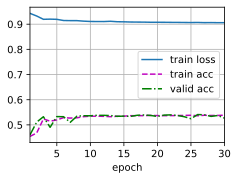

In [22]:
num_epochs = 30
train(net, train_iter, valid_iter,loss, num_epochs, updater)

In [1]:
evaluate_accuracy(net,test_iter)
net.eval()
y_hat = net(X_test)
y_hat = y_hat.argmax(axis=1)
cmp = y_hat.type(Y_test.dtype) == Y_test
float(cmp.type(Y_test.dtype).sum())/len(y_hat)

NameError: name 'evaluate_accuracy' is not defined

In [194]:
# # 训练损失总和、训练准确度总和、样本数
# # metric = d2l.Accumulator(3)
# for i in range(5):

#     for X,Y in train_iter:
#         y_hat = net(X)
#     #     print(y_hat,Y[:,0])
#     #     break

#         l = loss(y_hat,Y)

#         updater.zero_grad()
#         l.mean().backward()
#         updater.step()
    
#     y_p = net(X_train)
#     v_p = net(X_valid)
#     t_p = net(X_test)
#     print(loss(y_p,Y_train).mean())
#     print(accuracy(y_p,Y_train) / y_p.shape[0],accuracy(v_p,Y_valid) / v_p.shape[0],accuracy(t_p,Y_test) / t_p.shape[0] )
    
# #     metric.add(float(l.sum()), accuracy(y_hat, y), y.numel()) 
    

In [158]:
def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1, keepdims=True)
    return X_exp / partition  # 这里应用了广播机制

In [193]:
# softmax(net(X_valid))